In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.ticker as ticker

from scipy.interpolate import interp1d


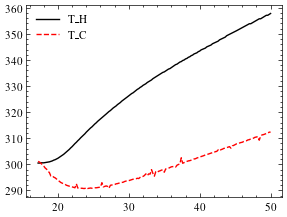

In [2]:
# Read and process the CSV file
df = pd.read_csv("test.csv")
df.columns = ["T_H", "T_C"]
df.insert(0, "Time", [i * 0.2 for i in range(len(df))])
df["T_H"] += 273  # Convert to Kelvin
df["T_C"] += 273


# Find the index where T_C starts dropping
drop_index = df.index[df["T_C"].diff() < -0.5][0]

# find end index (50s)
end_index = df.index[df["Time"] > 50][0]

#change df so it is from drop to end
df = df[drop_index:end_index]

# plot
plt.style.use(['science','ieee'])
plt.rcParams.update({'figure.dpi': '100'})
plt.plot(df["Time"], df["T_H"], label="T_H")
plt.plot(df["Time"], df["T_C"], label="T_C")
plt.legend()
plt.show()


In [3]:
# Constants and Parameters
k = 0.075  # Thermal conductivity of NOVEC 7000 [W/mK]
L_c = 0.75 / 1000  # Thickness of the fluid layer [m]
h = 5  # Convective heat transfer coefficient [W/m^2K]

# Peltier Device Parameters
n = 126  # Number of thermocouples in the Peltier device
# Average Seebeck coefficient for N type and P type (in V/K)
alpha_N = (205 + 215) / 2 * 1e-6
alpha_P = (220 + 230) / 2 * 1e-6

# Use an average alpha for the simulation (assuming a mix of N and P types)
alpha = (alpha_N + alpha_P) / 2

I = 2  # Current [A]

# Average Electrical resistance (converted from µΩ·cm to Ohms)
# R = (1000 + 1050) / 2 * 1e-6 * 0.01  # Conversion factor for cm to m
R = 0.75

V = I*R  # Voltage [V]

P = V*I  # Power [W]
print("Power:", P)


# Average Thermal conductivity for N type and P type (in W/mK)
K_N = (1.3 + 1.4) / 2
K_P = (1.4 + 1.6) / 2

# Use an average K for the simulation (assuming a mix of N and P types)
K = (K_N + K_P) / 2
# T_h = 333  # Hot side temperature [K]
# T_c = 293  # Cold side temperature [K]
T_inf = 293  # Ambient temperature [K]
A = 0.0004  # Surface area [m^2]
p = 1700  # Density of NOVEC 7000 [kg/m^3]
C_p = 1100  # Specific heat capacity [J/kgK]
v = 13.5e-6  # volume [m^3]

# Biot Number Calculation
B_i = h * L_c / k

# Check if Biot Number is less than 0.1 for 1-D assumption
if B_i < 0.1:
    print("1-D assumption is valid")
else:
    print("1-D assumption may not be valid")

print(df)
# Get slope of T_C for cooling_power by taking rise over run from initial point to minimum
cooling_power = (df["T_C"].iloc[0] - df["T_C"].min()) / (df["Time"].iloc[0] - df["Time"].iloc[df["T_C"].idxmin()])

# Get slope of T_H for exp_heating_power by taking rise over run from initial to max point
exp_heating_power = (df["T_H"].iloc[0] - df["T_H"].max()) / (df["Time"].iloc[0] - df["Time"].iloc[df["T_H"].idxmax()])

print("Slope:", cooling_power)
print("Slope2:", exp_heating_power)

## ADD pVcv 

Power: 3.0
1-D assumption is valid
     Time     T_H     T_C
86   17.2  300.49  301.13
87   17.4  300.49  300.86
88   17.6  300.58  300.40
89   17.8  300.58  299.85
90   18.0  300.58  299.31
..    ...     ...     ...
246  49.2  356.78  311.59
247  49.4  357.12  311.80
248  49.6  357.12  311.91
249  49.8  357.46  312.33
250  50.0  357.81  312.33

[165 rows x 3 columns]


IndexError: single positional indexer is out-of-bounds

In [4]:
heating_power = P - abs(cooling_power)
print("Heating power:", heating_power)


Heating power: 2.548260869565218


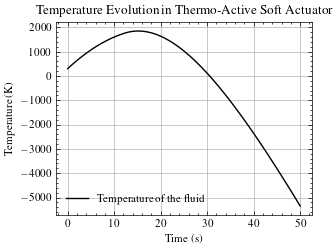

In [5]:
# Make df_from_drop["T_H"] and df_from_drop["T_C"] into functions of time
T_h_int = interp1d(df["Time"], df["T_H"], kind="linear", fill_value="extrapolate")
T_c_int = interp1d(df["Time"], df["T_C"], kind="linear", fill_value="extrapolate")

# Define the ODE function
def heatModel(t, T):
    T_h = T_h_int(t)
    T_c = T_c_int(t)
    q_dot_H = n * (alpha * T_h * I + 0.5 * I**2 * R - K * (T_h - T_c))
    dTdt = (h * A * (T - T_inf) + q_dot_H) / (p * v * C_p)
    return dTdt

# Define the time span and initial condition for the temperature
time_span = [0, df["Time"].iloc[-1]]  # From 0 to the last time in CSV
T_initial = T_h_int(0)  # Initial temperature of the fluid in Kelvin, assuming time starts at 0

# Solve ODE
sol = solve_ivp(
    heatModel,
    time_span,
    [T_initial],  # T_initial should be in list form as solve_ivp expects an array of initial conditions
    method="RK45",
    t_eval=np.linspace(0, df["Time"].iloc[-1], 100),
)

# Plotting the results
plt.plot(sol.t, sol.y[0], label="Temperature of the fluid")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.title("Temperature Evolution in Thermo-Active Soft Actuator")
plt.legend()
plt.grid(True)
plt.show()


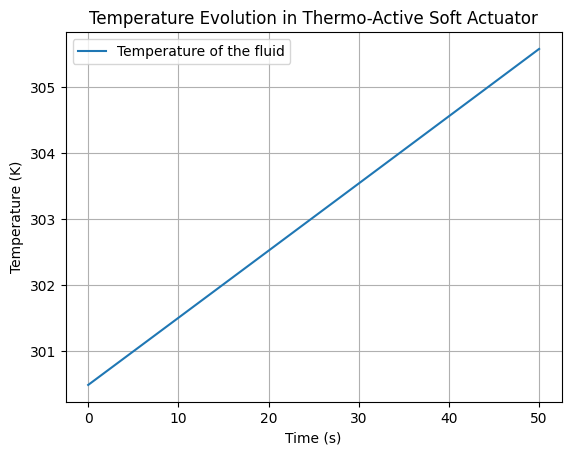

In [ ]:
# Assuming T_initial is a scalar representing the initial temperature
T_initial = T_h_int(0)  # or whatever your initial temperature is

def heatModel2(t, T):
    dTdt = (h * A * (T - T_inf) + heating_power) / (p * v * C_p)
    return dTdt

# Solve ODE
sol = solve_ivp(
    heatModel2,
    time_span,
    [T_initial],  # Wrap T_initial in a list or array
    method="RK45",
    t_eval=np.linspace(0, df["Time"].iloc[-1], 100),
)

# Plotting the results, in regular notation, large figure size
plt.plot(sol.t, sol.y[0], label="Temperature of the fluid")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.title("Temperature Evolution in Thermo-Active Soft Actuator")
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()